# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-0.951326,True,2.302902
1,0.330673,True,7.083304
2,2.158317,False,5.955331
3,-0.305575,True,3.450573
4,0.645392,False,2.239603
...,...,...,...
995,-0.657110,False,-0.773213
996,0.063507,True,6.701597
997,-0.888306,True,1.065233
998,1.268063,True,8.862945


<AxesSubplot:xlabel='v0'>

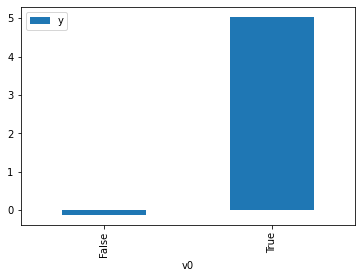

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

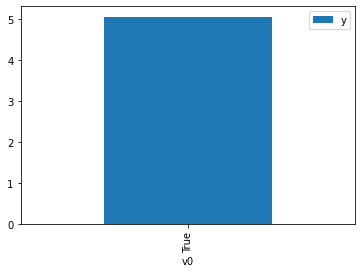

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-1.318332,False,-4.824049,0.697116,1.434482
1,-0.879405,False,-3.024307,0.632371,1.581351
2,0.421471,False,1.732868,0.420518,2.378020
3,-1.046487,False,-2.926815,0.657742,1.520353
4,0.421471,False,1.732868,0.420518,2.378020
...,...,...,...,...,...
995,-0.449341,False,-2.731838,0.563918,1.773306
996,1.230326,False,2.961774,0.297910,3.356722
997,0.950006,False,1.537329,0.338206,2.956774
998,-0.858696,False,-2.662310,0.629171,1.589394


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,1.100654,True,7.437174,0.683790,1.462438
1,-1.469141,True,0.906198,0.282184,3.543783
2,1.165482,True,7.494994,0.693015,1.442971
3,0.449681,True,6.193776,0.584036,1.712224
4,0.913075,True,8.388175,0.656288,1.523721
...,...,...,...,...,...
995,0.106234,True,5.805635,0.527848,1.894484
996,-1.226782,True,1.890955,0.315860,3.165959
997,1.149310,True,7.741266,0.690728,1.447749
998,0.743155,True,7.247851,0.630431,1.586217


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.962
Model:                            OLS   Adj. R-squared (uncentered):              0.962
Method:                 Least Squares   F-statistic:                          1.277e+04
Date:                Fri, 12 Aug 2022   Prob (F-statistic):                        0.00
Time:                        21:10:49   Log-Likelihood:                         -1390.0
No. Observations:                1000   AIC:                                      2784.
Df Residuals:                     998   BIC:                                      2794.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.6672      0.030     87.739      0.000       2.608       2.727
x2             5.0532      0.044    114.401      0.000       4.966       5.140
==============================================================================
Omnibus:                        0.424   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.809   Jarque-Bera (JB):                0.331
Skew:                          -0.035   Prob(JB):                        0.847
Kurtosis:                       3.056   Cond. No.                         1.53
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""